# 파트 08
----
가격변화 시계열 탐색분석을 하는 도중 패턴이 구분되는 점을 발견하여 클러스터링을 통해 두 그룹으로 나눈다. 여기서 이루어지는 클러스터링으로 추후 시계열 분석 뿐만 아파트 매매 금액 추정 회귀분석에도 도움이 될 것으로 예상된다. 주목할 점으로는 클러스터링을 통해 대체적으로 수도권과 비수도권 지역이 서로 다른 시계열 패턴을 보인다는 것을 알 수 있다.

In [39]:
%matplotlib inline
import re
from __future__ import division
from __future__ import print_function
import sklearn.preprocessing
import random

In [40]:
# setting the folder path and read in data
path = 'raw_data\\'
df_y = pd.read_csv(path + '07_pop_estate_year.csv', encoding='utf-8')
df_m = pd.read_csv(path + '07_pop_estate_month.csv', encoding='utf-8')

In [41]:
# take only those with enough trading volume per month
min_trade_vol = 20
df_m_t = df_m.loc[df_m.trade_vol >= min_trade_vol]

# series indicating those area_codes with enough data points
sr_temp = (df_m_t.groupby('area_code').count().year == 120)

# take only those with enough data points
df_m_t = df_m_t.loc[df_m_t.area_code.isin(sr_temp[sr_temp].index)]

In [42]:
# make a copy for convenience
df = df_m_t.groupby(['area_code', 'year', 'month']).agg({'trade_vol': 'sum', 'ppa_median': 'sum', 'ppa_median_log': 'sum'})

In [43]:
df_ni = df.reset_index()

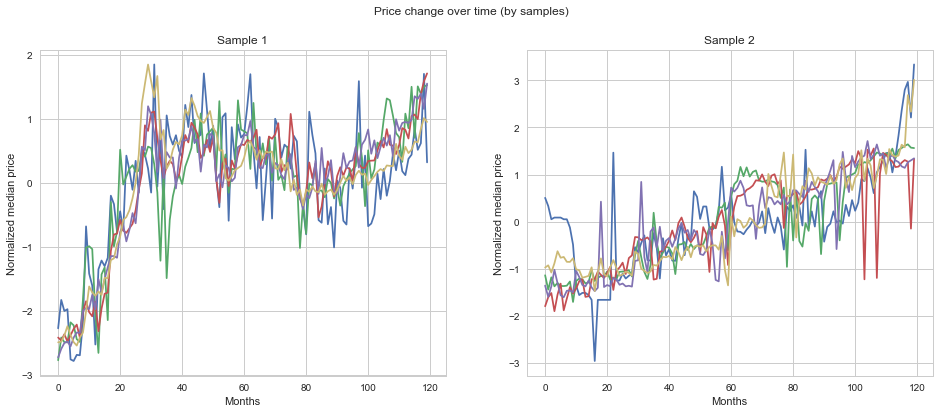

In [44]:
# we clearly see that there are different types
plt.figure(figsize=(16, 6))
plt.suptitle('Price change over time (by samples)')

plt.subplot(1, 2, 1)
for i in df.index.levels[0][:5]:
    plt.plot(sk.preprocessing.scale(df.loc[i].ppa_median.values))
plt.title('Sample 1')
plt.xlabel('Months')
plt.ylabel('Normalized median price')

plt.subplot(1, 2, 2)
for i in df.index.levels[0][-5:]:
    plt.plot(sk.preprocessing.scale(df.loc[i].ppa_median.values))
plt.title('Sample 2')
plt.xlabel('Months')
plt.ylabel('Normalized median price')

In [45]:
# we go for 2 clusters
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=100)

In [46]:
df_temp = df_m_t.loc[:, ['year', 'month', 'area_code', 'ppa_median']]
df_temp = df_temp.groupby(['area_code', 'year', 'month']).sum()

In [47]:
random.seed(0)
scaler_X = sk.preprocessing.StandardScaler()
scaler_X.fit(df_temp.unstack(0))
model.fit(scaler_X.transform(df_temp.unstack(0)).T)
df_temp['label'] = model.labels_.repeat(120)

In [48]:
def get_rand_area(df, l, n):
    return random.sample(df.loc[df.label == l].reset_index().area_code.unique(), k=n)

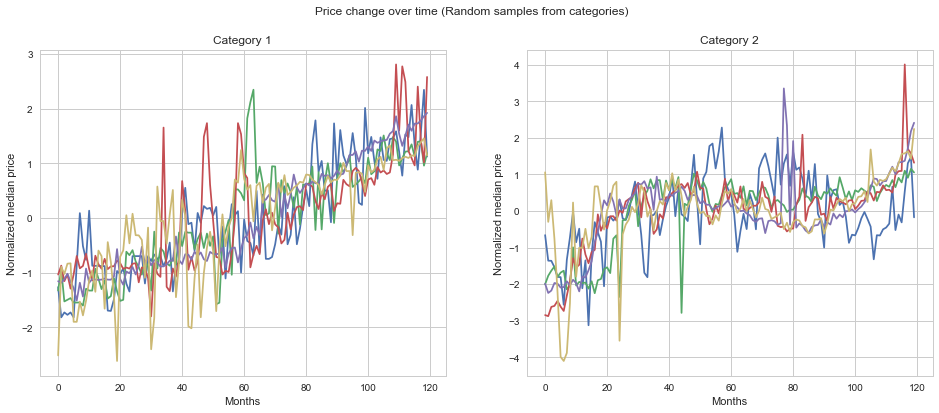

In [49]:
random.seed(0)
plt.figure(figsize=(16, 6))
plt.suptitle('Price change over time (Random samples from categories)')

plt.subplot(1, 2, 1)
for i in get_rand_area(df_temp, 0, 5):
    plt.plot(sk.preprocessing.scale(df_temp.loc[i].ppa_median.values))
plt.title('Category 1')
plt.xlabel('Months')
plt.ylabel('Normalized median price')

plt.subplot(1, 2, 2)
for i in get_rand_area(df_temp, 1, 5):
    plt.plot(sk.preprocessing.scale(df_temp.loc[i].ppa_median.values))
plt.title('Category 2')
plt.xlabel('Months')
plt.ylabel('Normalized median price')

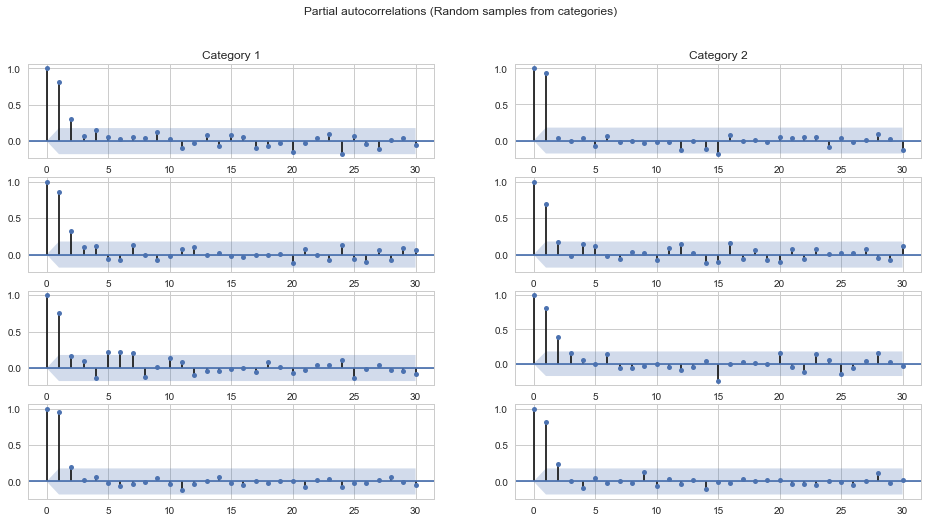

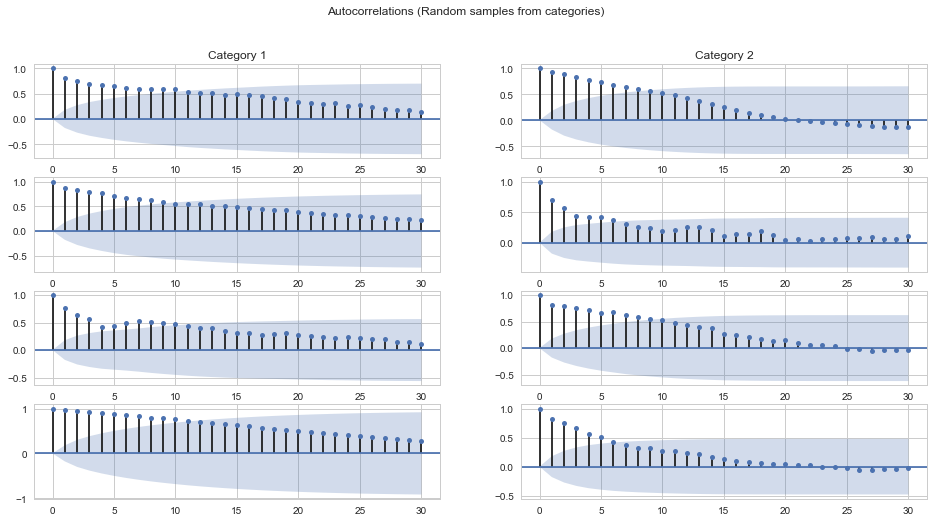

In [50]:
# randomly select a number of time series from each category
# and do a simple ACF and PACF analysis to see if clustering was successful
random.seed(0)
n = 4
lags = 30
rand_area = [get_rand_area(df_temp, 0, n), get_rand_area(df_temp, 1, n)]

figure, ax = plt.subplots(n, 2)
figure.set_size_inches(16, 8)
figure.suptitle('Partial autocorrelations (Random samples from categories)')
for area_code, i in zip(rand_area[0], range(n)):
    sm.graphics.tsa.plot_pacf(df_temp.loc[area_code].ppa_median.values, lags=lags, ax=ax[i][0])
    ax[i][0].set_title('')
for area_code, i in zip(rand_area[1], range(n)):
    sm.graphics.tsa.plot_pacf(df_temp.loc[area_code].ppa_median.values, lags=lags, ax=ax[i][1])
    ax[i][1].set_title('')
ax[0][0].set_title('Category 1')
ax[0][1].set_title('Category 2')

figure, ax = plt.subplots(n, 2)
figure.set_size_inches(16, 8)
figure.suptitle('Autocorrelations (Random samples from categories)')
for area_code, i in zip(rand_area[0], range(n)):
    sm.graphics.tsa.plot_acf(df_temp.loc[area_code].ppa_median.values, lags=lags, ax=ax[i][0])
    ax[i][0].set_title('')
for area_code, i in zip(rand_area[1], range(n)):
    sm.graphics.tsa.plot_acf(df_temp.loc[area_code].ppa_median.values, lags=lags, ax=ax[i][1])
    ax[i][1].set_title('')
ax[0][0].set_title('Category 1')
ax[0][1].set_title('Category 2')

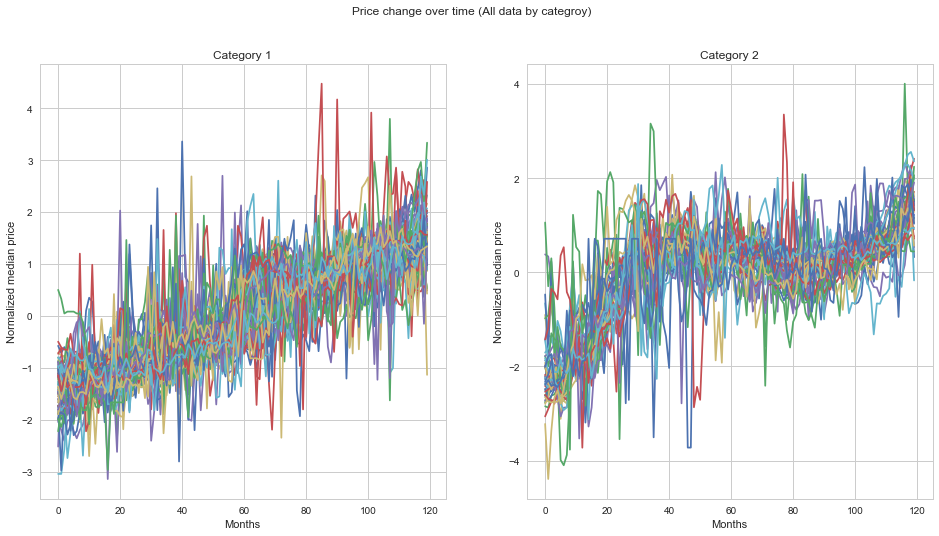

In [51]:
# checking how well things are categorized by drawing all plots
plt.figure(figsize=(16, 8))
plt.suptitle('Price change over time (All data by categroy)')

plt.subplot(1, 2, 1)
for i in df_temp.index.levels[0]:
    if df_temp.loc[i].label.min() == 0:
        plt.plot(sk.preprocessing.scale(df_temp.loc[i].ppa_median.values))
plt.title('Category 1')
plt.xlabel('Months')
plt.ylabel('Normalized median price')

plt.subplot(1, 2, 2)
for i in df_temp.index.levels[0]:
    if df_temp.loc[i].label.min() == 1:
        plt.plot(sk.preprocessing.scale(df_temp.loc[i].ppa_median.values))
plt.title('Category 2')
plt.xlabel('Months')
plt.ylabel('Normalized median price')

In [52]:
# adding the newly obtained labels
df_m_t = df_m_t.groupby(['area_code', 'year', 'month']).sum()
df_m_t['label'] = df_temp.label
df_m_t = df_m_t.reset_index().groupby(['label', 'area_code', 'year', 'month']).sum()

In [53]:
# also label those grouped by years
df_y_t = df_y.groupby(['year', 'area_code']).sum()
df_y_t['label'] = df_m_t.reset_index(drop=False).groupby(['year', 'area_code']).agg({'label': lambda x: x.values[0]})
df_y_t = df_y_t.loc[~df_y_t.label.isnull()]

In [54]:
# trying to see how the areas are grouped
df_code = pd.read_csv(path + '06_code_to_address.csv', index_col=0, header=None, encoding='utf-8')

In [55]:
# helper function to let us check the values of a single column dataframe
def reshape_column_df(df, cols):
    df_arr = []
    for i in range(cols):
        df_arr.append(df[i::cols].reset_index(drop=True))
    return pd.concat(df_arr, ignore_index=True, axis=1)

In [56]:
df_temp = df_code.loc[df_y_t.loc[df_y_t.label == 0].reset_index().area_code.unique()]
reshape_column_df(df_temp, cols=5)

,0,1,2,3,4
0,부산광역시 영도구,부산광역시 부산진구,부산광역시 동래구,부산광역시 남구,부산광역시 북구
1,부산광역시 해운대구,부산광역시 사하구,부산광역시 금정구,부산광역시 연제구,부산광역시 수영구
2,부산광역시 사상구,대구광역시 동구,대구광역시 남구,대구광역시 북구,대구광역시 수성구
3,대구광역시 달서구,대구광역시 달성군,광주광역시 동구,광주광역시 서구,광주광역시 남구
4,광주광역시 북구,광주광역시 광산구,대전광역시 동구,대전광역시 중구,대전광역시 서구
5,대전광역시 유성구,대전광역시 대덕구,울산광역시 중구,울산광역시 남구,울산광역시 동구
6,울산광역시 북구,울산광역시 울주군,세종특별자치시 종촌동,경기도 수원시,경기도 평택시
7,경기도 오산시,경기도 의왕시,경기도 이천시,경기도 안성시,경기도 화성시
8,강원도 춘천시,강원도 원주시,강원도 강릉시,강원도 동해시,강원도 속초시
9,충청북도 청주시,충청북도 충주시,충청북도 제천시,충청북도 진천군,충청남도 천안시


In [57]:
df_temp = df_code.loc[df_y_t.loc[df_y_t.label == 1].reset_index().area_code.unique()]
reshape_column_df(df_temp, cols=5)

,0,1,2,3,4
0,서울특별시 용산구,서울특별시 광진구,서울특별시 동대문구,서울특별시 성북구,서울특별시 도봉구
1,서울특별시 노원구,서울특별시 은평구,서울특별시 서대문구,서울특별시 마포구,서울특별시 양천구
2,서울특별시 강서구,서울특별시 구로구,서울특별시 영등포구,서울특별시 동작구,서울특별시 관악구
3,서울특별시 서초구,서울특별시 강남구,서울특별시 송파구,서울특별시 강동구,인천광역시 남구
4,인천광역시 연수구,인천광역시 남동구,인천광역시 부평구,인천광역시 계양구,인천광역시 서구
5,경기도 성남시,경기도 의정부시,경기도 안양시,경기도 부천시,경기도 광명시
6,경기도 안산시,경기도 고양시,경기도 구리시,경기도 남양주시,경기도 시흥시
7,경기도 군포시,경기도 하남시,경기도 용인시,경기도 파주시,경기도 김포시
8,경기도 광주시,경기도 양주시,충청남도 서산시,NaN,NaN


In [58]:
# export to files
df_m_t.reset_index().to_csv(path + '08_pop_estate_ts_month.csv', index=False, encoding='utf-8')
df_y_t.reset_index().to_csv(path + '08_pop_estate_ts_year.csv', index=False, encoding='utf-8')